In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score

from sklearn.preprocessing import StandardScaler
from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')


## Feature extraction

In [12]:
from sqlalchemy import create_engine
import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
# days_worked_data = pd.read_sql(days_worked_query,conn)
# print(datetime.now())
# apps_done_data = pd.read_sql(apps_done_query,conn)
# print(datetime.now())
# logs_done_data = pd.read_sql(logs_done_query,conn)
# print(datetime.now())
# print(datetime.now())
# texts_received_data = pd.read_sql(texts_received_query, conn)
# print(datetime.now())
# login_events_data = pd.read_sql(logins_events_query, conn)
# print(datetime.now())
#
# login_events_data.to_csv('../data/login_events_data.csv', index = False)
# days_worked_data.to_csv('../data/days_worked_data.csv', index = False)
# logs_done_data.to_csv('../data/logs_done_data.csv', index = False)
# apps_done_data.to_csv('../data/apps_done_data.csv', index = False)
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)
# texts_received_data.to_csv('../data/texts_received_data.csv', index = False)



2021-09-08 14:32:17.042451
2021-09-08 14:50:24.548010
2021-09-08 15:09:23.491990


## Feature engineering

In [15]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')
days_worked_data = pd.read_csv('../data/days_worked_data.csv')
apps_done_data = pd.read_csv('../data/apps_done_data.csv')
logs_done_data = pd.read_csv('../data/logs_done_data.csv')
texts_received_data = pd.read_csv('../data/texts_received_data.csv')
logins_events_data = pd.read_csv('../data/logins_events_data.csv')

In [270]:
days_worked_data['date'] = days_worked_data.date.apply(lambda x:str(x))
logs_done_data['date'] = logs_done_data.date.apply(lambda x:str(x))
texts_received_data['date'] = texts_received_data.date.apply(lambda x:str(x))
apps_done_data['date'] = apps_done_data.date.apply(lambda x:str(x))

training_data['date_sent_at'] = pd.to_datetime(training_data['sent_at'],format='%Y-%m-%d').dt.date.apply(lambda x:str(x))

print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(days_worked_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(apps_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(logs_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(texts_received_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)

all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)


target = 'carer_applied_in_8hrs'

(2246563, 38)
(2246563, 39)
(2246563, 69)
(2246563, 70)
(2246563, 73)
(2246563, 75)
(2246563, 77)
(2246563, 77)
(2246563, 79)
(1963934, 79)


['placement_ad_id',
 'match_request_id',
 'carer_id',
 'sent_at',
 'updated_at',
 'sms_type',
 'carer_applied_in_8hrs',
 'lead_time',
 'ongoing',
 'min_provider_rate',
 'one_off_payments_total',
 'licence_needed',
 'car_needed',
 'moving_handling',
 'dementia',
 'mental_health_issues',
 'hoist',
 'parkinsons',
 'stroke',
 'alzheimers',
 'stoma',
 'diabetes',
 'peg',
 'has_wifi',
 'smoking',
 'has_dogs',
 'has_cats',
 'has_two_crs',
 'max_cr_age',
 'recipient_1_male',
 'ethnicities_at_risk_WHITE_ALL',
 'ethnicities_at_risk_MIXED_ALL',
 'ethnicities_at_risk_BLACK_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'latitude',
 'longitude',
 'date_sent_at',
 'carer_logged_in_7_days',
 'set_at',
 'ethnicityExclusion_ARAB_ALL',
 'ethnicityExclusion_ASIAN_ALL',
 'ethnicityExclusion_BLACK_ALL',
 'ethnicityExclusion_MIXED_ALL',
 'ethnicityExclusion_WHITE_ALL',
 'genderExclusion_MALE',
 'maxDistance_50',
 'maxDistance_100',
 'maxDistance_400',
 'petsExclusion_CATS',
 'pets

In [271]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[all_data['carer_applied_in_8hrs']==0].sample(frac=0.01, random_state=1992)

df = pd.concat([X1,X0], axis = 0)
df

,placement_ad_id,match_request_id,carer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,min_provider_rate,...,distance_km,start_date_time,carer_worked_in_7_days,carer_worked_in_30_days,days_worked_past_90,apps_past_7_days,date_x,login_past_7_days,date_y,texts_past_30_days
19,plad_pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9...,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,p100093502,2021-08-17 11:29:26,2021-08-17 11:28:26,initialPromotionSent,1,34,1,700.0,...,64.0,2021-08-15 00:00:00,1.0,1.0,7.0,3.0,2021-08-17,43.0,2021-08-17,83.0
27,plad_pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a...,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,p100139148,2019-12-30 11:44:46,2019-12-30 11:36:45,initialPromotionSent,1,7,0,550.0,...,346.0,2019-12-30 00:00:00,1.0,1.0,25.0,21.0,2019-12-30,45.0,2019-12-30,53.0
82,plad_pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8...,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,p100139148,2020-02-07 16:44:36,2020-02-07 16:36:02,initialPromotionSent,1,4,1,550.0,...,8.0,2020-01-12 00:00:00,0.0,1.0,29.0,NaN,2020-02-07,15.0,2020-02-07,97.0
149,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,600.0,...,417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-02,100.0
430,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,650.0,...,421.0,2020-02-20 00:00:00,0.0,0.0,NaN,1.0,2020-08-17,17.0,2020-08-17,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283285,plad_pl_s0dipnm56vU6_BG3x-beb7b292-1a54-4bc9-8...,pl_s0dipnm56vU6_BG3x-beb7b292-1a54-4bc9-8777-3...,p573464,2020-06-12 10:12:42,2020-06-12 08:58:18,customListSent,0,3,0,575.0,...,473.0,2020-05-03 00:00:00,0.0,0.0,42.0,4.0,2020-06-12,36.0,2020-06-12,91.0
1767601,plad_pl_s0oQACzhYn61_jkZg-ceb1ca09-232f-4301-9...,pl_s0oQACzhYn61_jkZg-ceb1ca09-232f-4301-933c-b...,p163113365,2020-09-18 11:35:25,2020-09-18 08:46:04,customListSent,0,5,1,700.0,...,339.0,2019-08-15 00:00:00,0.0,0.0,NaN,NaN,NaN,NaN,2020-09-18,156.0
1010757,plad_pl_s03YivoXJ1lA_tZHU-d7220c1a-0df3-46f9-8...,pl_s03YivoXJ1lA_tZHU-d7220c1a-0df3-46f9-8b26-e...,p254565487,2021-02-12 11:28:00,2021-02-11 14:05:31,customListSent,0,3,0,560.0,...,441.0,2021-01-16 00:00:00,0.0,1.0,45.0,NaN,2021-02-12,2.0,2021-02-12,46.0
1158244,plad_pl_s0A62FCskFAS_W6dS-8b8fcaa5-1a60-42fb-9...,pl_s0A62FCskFAS_W6dS-8b8fcaa5-1a60-42fb-93e8-9...,p255958616,2020-07-15 16:23:36,2020-07-15 14:27:17,customListSent,0,2,0,610.0,...,364.0,2020-05-20 00:00:00,0.0,0.0,10.0,NaN,NaN,NaN,2020-07-15,36.0


In [272]:
df['texts_past_30_days'].replace(np.nan,0,inplace = True)
df['login_past_7_days'].replace(np.nan,0,inplace = True)
df['apps_past_7_days'].replace(np.nan,0,inplace = True)
df['days_worked_past_90'].replace(np.nan,0,inplace = True)
df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)

df = pd.get_dummies(df,columns=['sms_type'],drop_first=True)

df['log_lead_time'] = np.log(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['exp_lead_time'] = np.exp(np.where(df['lead_time']>0,df['lead_time'],0.01))


#carer likes X and X is there
df['met_licence'] = df['has_licence'] * df['licence_needed']
df['met_car'] = df['has_car'] * df['car_needed']

df['met_moving_handling'] = df['moving_handling'] * df['carer_moving_handling']
df['met_stoma'] = df['stoma'] * df['carer_stoma']
df['met_dementia'] = df['dementia'] * df['carer_dementia']
df['met_alzheimers'] = df['alzheimers'] * df['carer_alzheimers']
df['met_parkinsons'] = df['parkinsons'] * df['carer_parkinsons']
df['met_stroke'] = df['stroke'] * df['carer_stroke']
df['met_diabetes'] = df['diabetes'] * df['carer_diabetes']
df['met_peg'] = df['peg'] * df['carer_peg']
df['met_hoist'] = df['hoist'] * df['carer_hoist']
df['met_mental_health_issue'] = df['mental_health_issues'] * df['carer_mental_health_issues']

df['met_distance_50'] = np.where((df['maxDistance_50']==1) & (df['distance_km']*1.61 <= 50),1,0 )
df['met_distance_100'] = np.where((df['maxDistance_100']==1) & (df['distance_km']*1.61 <= 100),1,0 )
df['met_distance_400'] = np.where((df['maxDistance_400']==1) & (df['distance_km']*1.61 <= 400),1,0 )

#carer doesn't like X and X is not there
df['met_smoking'] = np.where((df['smoking'] == 0 )& (df['smokingClientsExclusion'] ==1),1,0)
df['met_dogs'] = np.where((df['has_dogs'] == 0) & (df['petsExclusion_DOGS'] ==1),1,0)
df['met_cats'] = np.where((df['has_cats'] == 0 )& (df['petsExclusion_CATS'] ==1),1,0)
df['met_2crs'] = np.where((df['has_two_crs'] == 0) & (df['recipientNumberExclusion_2CRs'] ==1),1,0)
df['met_cr_gender'] = np.where((df['recipient_1_male'] == 0) & (df['genderExclusion_MALE'] ==1),1,0)

#carer doesn't like X but X is there
df['broken_ear_WHITE_ALL'] = df['ethnicities_at_risk_WHITE_ALL'] * df['ethnicityExclusion_WHITE_ALL']
df['broken_ear_MIXED_ALL'] = df['ethnicities_at_risk_MIXED_ALL']* df['ethnicityExclusion_MIXED_ALL']
df['broken_ear_BLACK_ALL'] = df['ethnicities_at_risk_BLACK_ALL'] * df['ethnicityExclusion_BLACK_ALL']
df['broken_ear_ASIAN_ALL'] = df['ethnicities_at_risk_ASIAN_ALL'] * df['ethnicityExclusion_ASIAN_ALL']
df['broken_ear_ARAB_ALL'] = df['ethnicityExclusion_ARAB_ALL'] * df['ethnicityExclusion_ARAB_ALL']

## Feature selection

In [267]:
df.columns.tolist()

['placement_ad_id',
 'match_request_id',
 'carer_id',
 'sent_at',
 'updated_at',
 'carer_applied_in_8hrs',
 'lead_time',
 'ongoing',
 'min_provider_rate',
 'one_off_payments_total',
 'licence_needed',
 'car_needed',
 'moving_handling',
 'dementia',
 'mental_health_issues',
 'hoist',
 'parkinsons',
 'stroke',
 'alzheimers',
 'stoma',
 'diabetes',
 'peg',
 'has_wifi',
 'smoking',
 'has_dogs',
 'has_cats',
 'has_two_crs',
 'max_cr_age',
 'recipient_1_male',
 'ethnicities_at_risk_WHITE_ALL',
 'ethnicities_at_risk_MIXED_ALL',
 'ethnicities_at_risk_BLACK_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'latitude',
 'longitude',
 'date_sent_at',
 'carer_logged_in_7_days',
 'set_at',
 'ethnicityExclusion_ARAB_ALL',
 'ethnicityExclusion_ASIAN_ALL',
 'ethnicityExclusion_BLACK_ALL',
 'ethnicityExclusion_MIXED_ALL',
 'ethnicityExclusion_WHITE_ALL',
 'genderExclusion_MALE',
 'maxDistance_50',
 'maxDistance_100',
 'maxDistance_400',
 'petsExclusion_CATS',
 'petsExclusion_DOG

In [273]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'placement_ad_id',
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at'] if x in predictors]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [302]:
for p in predictors:
    if df[p].isna().sum()>0:
        print(p,df[p].isna().sum())

print(df.shape)
df = df.loc[df[predictors].notnull().all(axis=1)]
print(df.shape)

X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target, test_size=0.15)

(34633, 110)
(34633, 110)


In [255]:
scaler = StandardScaler()
model = LogisticRegression()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)

array([1, 0])

In [121]:
n_features = 10
X = X_train
y = np.ravel(y_train)

recall_scorer = make_scorer(recall_score, greater_is_better=True)
results = select_features(model, n_features, y, X,scoring=recall_scorer)

Running for 1 features
Selected features: ['one_off_payments_total']
Fit summary: 0.5305160625055038 (0.5164168451106352 to 0.5479400749063671)
Running for 2 features
Selected features: ['one_off_payments_total', 'has_dogs']
Fit summary: 0.5969758990894455 (0.5785153461812991 to 0.6067415730337079)
Running for 3 features
Selected features: ['one_off_payments_total', 'has_dogs', 'broken_ear_MIXED_ALL']
Fit summary: 0.59697867797216 (0.5781584582441114 to 0.6067415730337079)
Running for 4 features
Selected features: ['one_off_payments_total', 'has_dogs', 'carer_hoist', 'broken_ear_MIXED_ALL']
Fit summary: 0.59697867797216 (0.5781584582441114 to 0.6067415730337079)
Running for 5 features
Selected features: ['one_off_payments_total', 'has_dogs', 'carer_hoist', 'exp_lead_time', 'broken_ear_MIXED_ALL']
Fit summary: 0.59697867797216 (0.5781584582441114 to 0.6067415730337079)
Running for 6 features
Selected features: ['one_off_payments_total', 'has_dogs', 'carer_hoist', 'exp_lead_time', 'broke

In [ ]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

In [181]:
predictors

['lead_time',
 'ongoing',
 'min_provider_rate',
 'one_off_payments_total',
 'licence_needed',
 'car_needed',
 'moving_handling',
 'dementia',
 'mental_health_issues',
 'hoist',
 'parkinsons',
 'stroke',
 'alzheimers',
 'stoma',
 'diabetes',
 'peg',
 'has_wifi',
 'smoking',
 'has_dogs',
 'has_cats',
 'has_two_crs',
 'max_cr_age',
 'recipient_1_male',
 'ethnicities_at_risk_WHITE_ALL',
 'ethnicities_at_risk_MIXED_ALL',
 'ethnicities_at_risk_BLACK_ALL',
 'ethnicities_at_risk_ASIAN_ALL',
 'ethnicities_at_risk_ARAB_ALL',
 'carer_logged_in_7_days',
 'ethnicityExclusion_ARAB_ALL',
 'ethnicityExclusion_ASIAN_ALL',
 'ethnicityExclusion_BLACK_ALL',
 'ethnicityExclusion_MIXED_ALL',
 'ethnicityExclusion_WHITE_ALL',
 'genderExclusion_MALE',
 'maxDistance_50',
 'maxDistance_100',
 'maxDistance_400',
 'petsExclusion_CATS',
 'petsExclusion_DOGS',
 'recipientNumberExclusion_2CRs',
 'smokingClientsExclusion',
 'has_licence',
 'has_car',
 'carer_moving_handling',
 'carer_dementia',
 'carer_mental_health_i

1

In [379]:
 # 'days_worked_past_90',
f_predictors = [
 'texts_past_30_days', 'apps_past_7_days','carer_logged_in_7_days'

]
model.fit(X_train[f_predictors], np.ravel(y_train))


preds = model.predict(X_eval[f_predictors])
print(f'Precision is {precision_score(y_eval,preds)}, recall is {recall_score(y_eval,preds)}, accuracy is {accuracy_score(y_eval,preds)}')

Precision is 0.8078797725426482, recall is 0.8141629144494474, accuracy is 0.8215591915303176


On a balanced sample (around 50% each applied/not applied), the model does a fair job at classifying positive examples
correctly, showing an accuracy of 58.4% together with a recall score of 61.2% on the evaluation set (not used for FS)

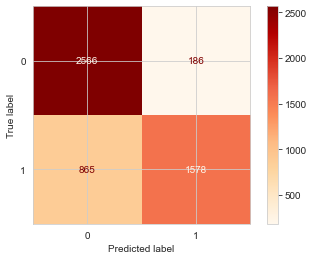

In [300]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')

Feature predictive importance is line with expectations,bonuses possibly reflecting location

  0%|          | 0/1000 [00:00<?, ?it/s]

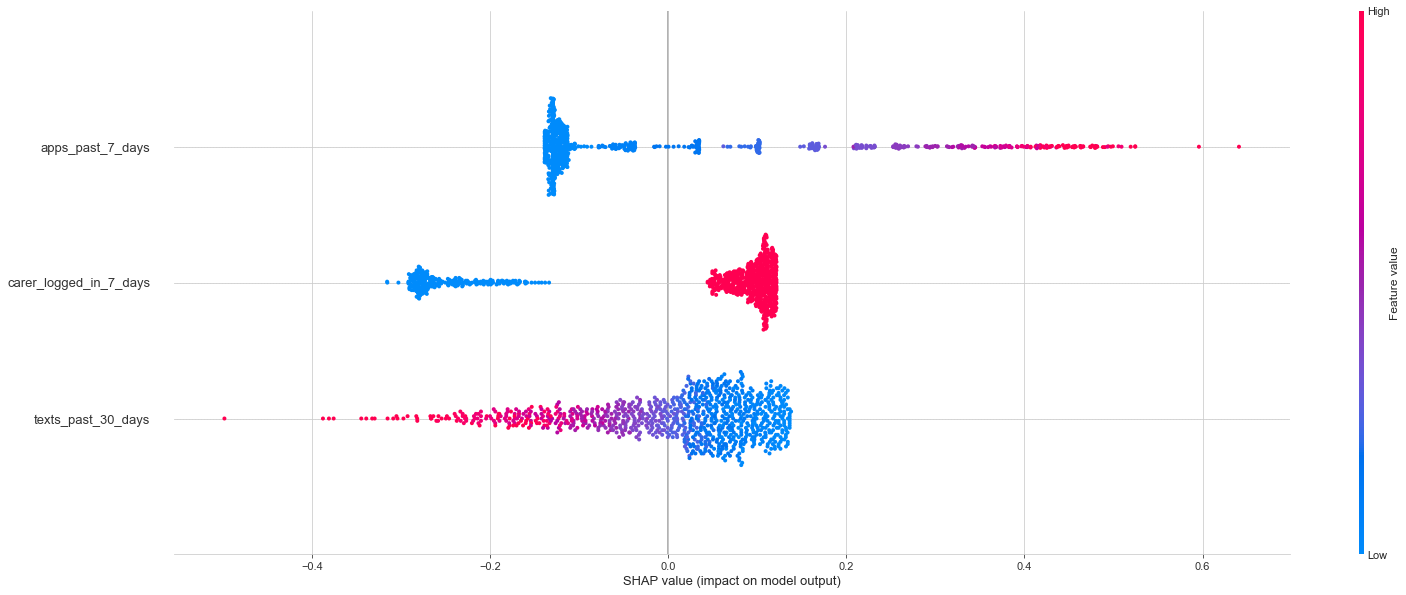

In [380]:
scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

masker = shap.maskers.Impute(data=scaler.transform(X_eval[f_predictors][:100]), )

model = LogisticRegression()
model.fit(X_eval[f_predictors],np.ravel(y_eval))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1]

explainer = shap.KernelExplainer(model_predict_proba, X_eval[f_predictors][:500], masker=masker)
shap_values = explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=10, show=False, plot_size=None )


In [ ]:
plot_shap_metrics(model,df,f_predictors,target)
